## Over-sampling with cross-validation

When we train a classifier, we want it to predict an outcome in a real life dataset. The real datasets, most likely, also have a class imbalance. Thus, it is important to evaluate the performance of the classifier, on a data set with the same distribution of classes, as the one we expect in real life.

This means, that the over-sampling methods should be performed on the dataset that we are going to use to train the classifier. But, **the performance of the model should be determined on a portion of the data, that was not re-sampled**.

In this notebook, we will use the imbalanced-learn pipeline, to set up various over-sampling solutions, in a way that we train the model on re-sampled data, but we evaluate performance on non-resampled data.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets

# to correctly set up the cross-validation
from imblearn.pipeline import make_pipeline


from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

In [2]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),

    'smote': SMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        n_jobs=4),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        n_jobs=4),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=4),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        n_jobs=4),

    'svm': SVMSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        n_jobs=4,
        svm_estimator=SVC(kernel='linear')),
}

In [3]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# print class imbalance

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance

# ***with cross-validation***

def run_model(X_train, y_train, oversampler=None):
    
    # set up the classifier
    rf = RandomForestClassifier(
            n_estimators=100, random_state=39, max_depth=3, n_jobs=4
        )
    
    # set up a scaler 
    # (as the oversampling techniques use KNN
    # we put the variables in the same scale)
    scaler = MinMaxScaler()
    
    # without sampling:
    if not oversampler:

        model = rf
    
    # set up a pipeline with sampling:
    else:
        
        # important to scale before the re-sampler
        # as the many of methods require the variables in 
        # a similar scale
        model = make_pipeline(
            scaler,
            oversampler,
            rf,
        )
        
        
    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:
    
    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled
    
    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the over-sampled data
    
    cv_results = cross_validate(
        model, # the random forest or the pipeline
        X_train, # the data that will be used in the cross-validation
        y_train, # the target
        scoring="average_precision", # the metric that we want to evaluate
        cv=3, # the cross-validation fold
    )

    print(
        'Random Forests average precision: {0} +/- {1}'.format(
        cv_results['test_score'].mean(), cv_results['test_score'].std()
        )
    )

    return cv_results['test_score'].mean(), cv_results['test_score'].std()

In [6]:
# now we train several models, with the different over-samplers and
# with cross-validation for each dataset

# to save the results
pr_mean_dict = {}
pr_std_dict = {}


for dataset in datasets_ls:
    
    # initiate a dictionary per dataset
    pr_mean_dict[dataset] = {}
    pr_std_dict[dataset] = {}
    
    print(dataset)
    
    # load dataset
    data = fetch_datasets()[dataset]
    
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,  
        data.target, 
        test_size=0.3,
        random_state=0,
    )
   
    
    # train model on data without re-sampling
    # with cross-validation
    aps_mean, aps_std = run_model(X_train, y_train)
    
    # store results
    pr_mean_dict[dataset]['full_data'] = aps_mean
    pr_std_dict[dataset]['full_data'] = aps_std
    
    print()
    
    for oversampler in oversampler_dict.keys():
        
        print(oversampler)
               
        # resample, train and evaluate performance
        # with cross-validation
        aps_mean, aps_std = run_model(X_train, y_train, oversampler_dict[oversampler])
        
        #store results
        pr_mean_dict[dataset][oversampler] = aps_mean
        pr_std_dict[dataset][oversampler] = aps_std
        print()
        
    print()

car_eval_34
Random Forests average precision: 0.74810907315696 +/- 0.06400476183857116

random
Random Forests average precision: 0.8433408505659911 +/- 0.07516648844294713

smote
Random Forests average precision: 0.799161726356635 +/- 0.06299511222351424

adasyn
Random Forests average precision: 0.8350198132335759 +/- 0.06334417984228251

border1
Random Forests average precision: 0.8329238005627132 +/- 0.05787117495290748

border2
Random Forests average precision: 0.8422458714349118 +/- 0.05973496265599144

svm
Random Forests average precision: 0.7438440287725605 +/- 0.05609132010915686


ecoli
Random Forests average precision: 0.6687434616841758 +/- 0.11512585309131046

random
Random Forests average precision: 0.5853702816801476 +/- 0.01634245823762112

smote
Random Forests average precision: 0.5902528240840609 +/- 0.05876172398967221

adasyn
Random Forests average precision: 0.5798786475869809 +/- 0.022512165969597257

border1
Random Forests average precision: 0.5823857212746102 +/- 

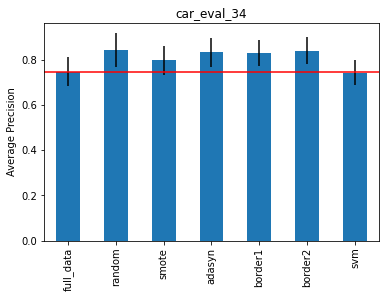

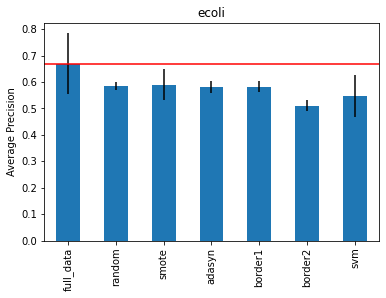

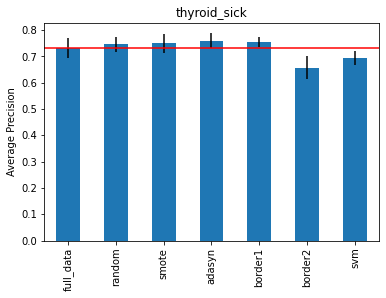

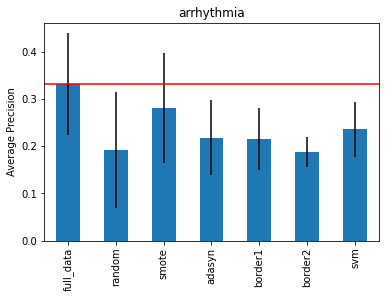

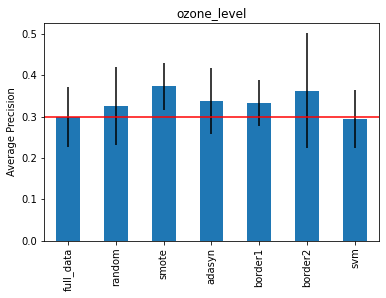

In [7]:
# Now we plot the performance of the model in the 
# left out fold, that was not resampled, from the X_train

for dataset in datasets_ls:
    
    pr_mean_s = pd.Series(pr_mean_dict[dataset])
    pr_std_s = pd.Series(pr_std_dict[dataset])
    
    pr_mean_s.plot.bar(yerr=[pr_std_s, pr_std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average Precision')
    plt.axhline(pr_mean_dict[dataset]['full_data'], color='r')
    plt.show()

**Different over-sampling techniques work better in different datasets.**